## 01b. Combine one-dimensional spectra;

This notebook aims at 
- 1.combining optimally extracted 1D spectra (from No.01a) at different dither positions.
- 2.then normalize the combined spectra to a flux estimated from direct images (i.e. broadband photometry)

This notebook will start with an optimally extracted 1D spextrum in the previous notebook, saved in a file named as "l3_nis_f115w_G150C_s00002_ndither0_1d_opt.fits" or so.
- One-dimensional spectra from each dither will be combined and saved in a file, named like "l3_nis_f115w_G150C_s00004_combine_1d_opt.fits". 
- Remember that this is not intended to combined spectra from the two different orientations (C&R), as each has a different spectral resolution depending on source morphology.
- Normalization of grism spectrum to each broadband filter photometry will imptove zeropoint calibration, which is critical in continuum fitting over multiple filters.

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
from scipy.integrate import simps
from urllib.request import urlretrieve
import tarfile

from astropy.convolution import Gaussian2DKernel
from astropy.io import fits
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.table import QTable
import astropy.units as u
from astropy.visualization import make_lupton_rgb, SqrtStretch, ImageNormalize, simple_norm
import astropy.wcs as wcs
from astropy.io import ascii

import astropy
print('astropy', astropy.__version__)

astropy 4.0.1.post1


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

In [4]:
import specutils
from specutils.fitting import continuum #, find_lines_threshold, find_lines_derivative
from specutils.spectra.spectrum1d import Spectrum1D
from astropy.nddata import StdDevUncertainty

print("Specutils: ",specutils.__version__)

Specutils:  1.0


### 0. Download notebook 01 products
These can be also obtained by running the notebooks.

In [ ]:
if not os.path.exists('./output'):
    import zipfile
    import urllib.request
    boxlink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/NIRISS_lensing_cluster/output.zip'
    boxfile = './output.zip'
    urllib.request.urlretrieve(boxlink, boxfile)
    zf = zipfile.ZipFile(boxfile, 'r')
    zf.extractall()
else:
    print('Already exists')

In [6]:
# Which data set?;
DIR_OUT = './output/'
filt = 'f200w'
grism = 'G150C'
id  = '00004'
ndither = 2 # Number of dithering positions.

### 1.Combine spectra from different dithers;

In [7]:
dithers = np.arange(0,ndither,1)
for dither in dithers:
    file_1d = '%sl3_nis_%s_%s_s%s_ndither%d_1d_opt.fits'%(DIR_OUT, filt, grism, id, dither)
    fd = fits.open(file_1d)[1].data
    if dither == 0:
        wave = fd['wavelength']
        flux = np.zeros((ndither,len(wave)),'float')
        flux_err = np.zeros((ndither,len(wave)),'float')
        flux[dither,:] = fd['flux']
        flux_err[dither,:] = fd['uncertainty']
    else:
        wave_tmp = fd['wavelength']
        flux_tmp = fd['flux']
        flux_err_tmp = fd['uncertainty']
        
        flux[dither,:] = np.interp(wave, wave_tmp, flux_tmp)
        flux_err[dither,:] = np.sqrt(np.interp(wave, wave_tmp, flux_err_tmp[:]**2))

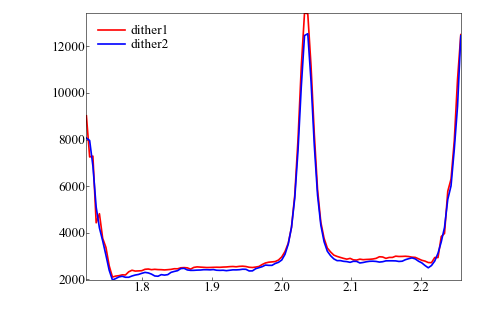

In [8]:
plt.plot(wave, flux[0,:], color='r', label='dither1')
plt.plot(wave, flux[1,:], color='b', label='dither2')
plt.legend(loc=2)

### Make weighted-average of the two spectra from different dither positions;

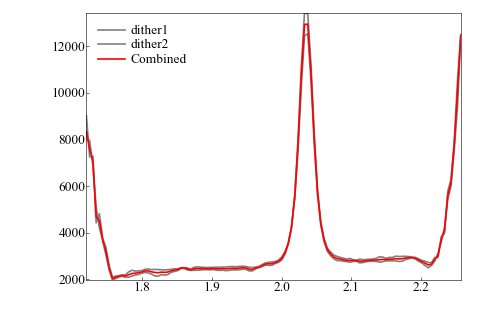

In [9]:
flux_combine = np.zeros(len(wave),'float')
flux_err_combine = np.zeros(len(wave),'float')

for ii in range(len(wave)):
    flux_combine[ii] = np.sum(flux[:,ii] * 1 / flux_err[:,ii]**2) / np.sum(1 / flux_err[:,ii]**2) 
    flux_err_combine[ii] = np.sqrt(np.sum(flux_err[:,ii]**2)) / len(flux_err[:,ii])

plt.plot(wave, flux[0,:], color='gray', label='dither1')
plt.plot(wave, flux[1,:], color='gray', label='dither2')
plt.plot(wave, flux_combine[:], color='r', label='Combined')
plt.legend(loc=2)

### 2.Continuum normalization;
Since NIRISS spectra may be affected background subtraction & contamination, which could lead to mismatch between filters, here we aim to normaliza spectra from filter to its broadband magnitude.

In [10]:
# Open broadband flux catalog from Notebook 01a;

# Flux are already in Fnu, with magzp = 25.0;
file = DIR_OUT+'l3_nis_flux.cat'

fd_cat = ascii.read(file)
id_cat = fd_cat['id']
magzp = 25.0

fd_cat

id,F309,E309,F310,E310,F311,E311,F308,E308,F1,E1,F4,E4,F6,E6,F202,E202,F203,E203,F204,E204,F205,E205
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,4.17638,0.208819,13.9316,0.696578,15.8489,0.792447,2.39883,0.119942,0.29134,0.014567,1.45747,0.0728736,2.22433,0.111217,3.49623,0.174812,6.11505,0.305752,10.5682,0.528409,14.9279,0.746397
2,4.17638,0.208819,13.9316,0.696578,15.8489,0.792447,2.39883,0.119942,0.29134,0.014567,1.45747,0.0728736,2.22433,0.111217,3.49623,0.174812,6.11505,0.305752,10.5682,0.528409,14.9279,0.746397
3,4.17638,0.208819,13.9316,0.696578,15.8489,0.792447,2.39883,0.119942,0.29134,0.014567,1.45747,0.0728736,2.22433,0.111217,3.49623,0.174812,6.11505,0.305752,10.5682,0.528409,14.9279,0.746397
4,11.2928,0.564638,16.2032,0.810159,15.8489,0.792447,7.68422,0.384211,5.01649,0.250825,6.48634,0.324317,6.8612,0.34306,8.86339,0.44317,14.0217,0.701084,16.248,0.8124,16.2181,0.810905
5,7.23103,0.361551,6.29216,0.314608,6.30957,0.315479,5.6079,0.280395,0.175227,0.00876133,0.206633,0.0103317,2.71144,0.135572,7.08598,0.354299,6.86752,0.343376,6.46845,0.323422,6.36796,0.318398
6,7.23103,0.361551,6.29216,0.314608,6.30957,0.315479,5.6079,0.280395,0.175227,0.00876133,0.206633,0.0103317,2.71144,0.135572,7.08598,0.354299,6.86752,0.343376,6.46845,0.323422,6.36796,0.318398
7,7.23103,0.361551,6.29216,0.314608,6.30957,0.315479,5.6079,0.280395,0.175227,0.00876133,0.206633,0.0103317,2.71144,0.135572,7.08598,0.354299,6.86752,0.343376,6.46845,0.323422,6.36796,0.318398


In [11]:
# Retrieve filter curves for NIRISS images;
url = 'https://jwst-docs.stsci.edu/files/73023162/73023163/1/1494860472234/NIRISS_Filters_2017May.tar.gz'

filename = 'tmp.tar.gz'
urlretrieve(url, filename)
my_tar = tarfile.open(filename)
my_tar.extractall('./')

Wavelength FilterTrans     PCE    
---------- ----------- -----------
       0.5         0.0         0.0
     0.501         0.0         0.0
     0.502         0.0         0.0
     0.503         0.0         0.0
     0.504         0.0         0.0
     0.505         0.0         0.0
     0.506         0.0         0.0
     0.507         0.0         0.0
     0.508         0.0         0.0
     0.509         0.0         0.0
       ...         ...         ...
      5.49 1.14149e-06 5.89206e-08
     5.491 1.15901e-06 5.86208e-08
     5.492 1.17562e-06 5.83295e-08
     5.493 1.19224e-06 5.80189e-08
     5.494 1.20426e-06 5.75614e-08
     5.495 1.21578e-06 5.70597e-08
     5.496  1.2271e-06 5.66351e-08
     5.497 1.23762e-06 5.61508e-08
     5.498 1.24814e-06 5.56559e-08
     5.499 1.25629e-06 5.51494e-08
       5.5 1.26205e-06 5.46377e-08
Length = 5001 rows


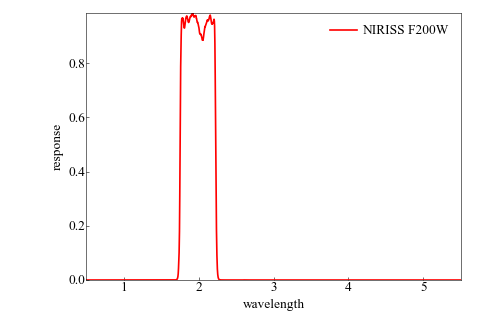

In [14]:
# Load fiter response:
DIR_FIL = './NIRISS_Filters/DATA/'

# The number corresponds to F200W in EAZY filter response;
eazy_filt = 311

# Read transmission data;
filt_data = ascii.read('%s/NIRISS_%s.txt'%(DIR_FIL, filt.upper()))
print(filt_data)
wave_filt = filt_data['Wavelength']
flux_filt = filt_data['FilterTrans']

plt.plot(wave_filt, flux_filt, ls='-', label='NIRISS %s'%filt.upper())
plt.xlabel('wavelength')
plt.ylabel('response')
plt.legend(loc=1)

In [15]:
# Define a small function for flux convolution with filters;
def filconv(lfil, ffil, l0, f0, DIR='', c=3e18):
    '''
    lfil : Wave array for filter response curve.
    ffil : Flux array for filter response curve.

    l0 : Wave array for spectrum, in f_nu, not f_lam
    f0 : Flux array for spectrum, in f_nu, not f_lam

    '''

    lmin  = np.min(lfil)
    lmax  = np.max(lfil)
    imin  = 0
    imax  = 0

    fhalf = np.max(ffil)/2.0
    con = (ffil>fhalf)
    lfwhml = np.min(lfil[con])
    lfwhmr = np.max(lfil[con])
    lcen = (lfwhmr+lfwhml)/2.

    lamS,spec = l0, f0  # Two columns with wavelength and flux density
    lamF,filt = lfil, ffil  # Two columns with wavelength and response in the range [0,1]
    filt_int = np.interp(lamS, lamF, filt)  # Interpolate Filter to common(spectra) wavelength axis
    wht = 1.

    if len(lamS)>0:
        I1 = simps(spec / lamS**2 * c * filt_int * lamS, lamS)  # Denominator for Fnu
        I2 = simps(filt_int/lamS, lamS) # Numerator
        fnu = I1/I2/c # Average flux density
    else:
        I1 = 0
        I2 = 0
        fnu = 0

    return lcen, fnu

In [16]:
# Convolve observed spectrum with the filter response.
# The input flux need to be in Fnu with magzp=25;

# Cut edge of observed flux;
con = (wave > 1.75) & (wave < 2.25)
lcen, fnu = filconv(wave_filt, flux_filt, wave[con], flux_combine[con], DIR='./')
print('Central wavelength and total flux are ;', lcen, fnu)

Central wavelength and total flux are ; 1.9885 3130.4558232154595


In [17]:
# Get normalization factor;
iix = np.where(id_cat[:] == int(id))
Cnorm = fd_cat['F%d'%(eazy_filt)][iix] / fnu
Cnorm

0.005062809026872241


In [18]:
# Wirte the normalized spectrum:
# Make it into a Spectrum1D instance.
file_1d = '%sl3_nis_%s_%s_s%s_combine_1d_opt.fits'%(DIR_OUT, filt, grism, id)

obs = Spectrum1D(spectral_axis=wave*u.um,
                 flux=flux_combine * Cnorm * u.dimensionless_unscaled,
                 uncertainty=StdDevUncertainty(flux_err_combine * Cnorm), unit='')
obs.write(file_1d, format='tabular-fits', overwrite=True)

### Repeat 1&2 for other filters too;

In [19]:
DIR_FIL = './NIRISS_Filters/DATA/'
filts  = ['f115w', 'f150w', 'f200w']
# The number corresponds to NIRISS filters in EAZY filter response;
eazy_filts = [309, 310, 311]

# Masks for problematic flux at edge;
mask_lw = [1.05, 1.35, 1.75]
mask_uw = [1.25, 1.65, 2.23]

for ff,filt in enumerate(filts):
    for dither in dithers:
        file_1d = '%sl3_nis_%s_%s_s%s_ndither%d_1d_opt.fits'%(DIR_OUT, filt, grism, id, dither)
        fd = fits.open(file_1d)[1].data
        if dither == 0:
            wave = fd['wavelength']
            flux = np.zeros((ndither, len(wave)), 'float')
            flux_err = np.zeros((ndither, len(wave)), 'float')

            flux[dither,:] = fd['flux']
            flux_err[dither,:] = fd['uncertainty']
        else:
            wave_tmp = fd['wavelength']
            flux_tmp = fd['flux']
            flux_err_tmp = fd['uncertainty']

            flux[dither,:] = np.interp(wave, wave_tmp, flux_tmp)
            flux_err[dither,:] = np.sqrt(np.interp(wave, wave_tmp, flux_err_tmp[:]**2))

    # Combine;
    flux_combine = np.zeros(len(wave), 'float')
    flux_err_combine = np.zeros(len(wave), 'float')

    for ii in range(len(wave)):
        flux_combine[ii] = np.sum(flux[:,ii] * 1 / flux_err[:,ii]**2) / np.sum(1 / flux_err[:,ii]**2) 
        flux_err_combine[ii] = np.sqrt(np.sum(flux_err[:,ii]**2)) / len(flux_err[:,ii])

    # Normalize;
    filt_data = ascii.read('%s/NIRISS_%s.txt'%(DIR_FIL, filt.upper()))
    wave_filt = filt_data['Wavelength']
    flux_filt = filt_data['FilterTrans']

    con = (wave > mask_lw[ff]) & (wave < mask_uw[ff])
    lcen, fnu = filconv(wave_filt, flux_filt, wave[con], flux_combine[con])
    iix   = np.where(id_cat[:] == int(id))
    Cnorm = fd_cat['F%d'%(eazy_filts[ff])][iix] / fnu

    # Wirte:
    file_1d = '%sl3_nis_%s_%s_s%s_combine_1d_opt.fits'%(DIR_OUT, filt, grism, id)

    obs = Spectrum1D(spectral_axis=wave*u.um,
                     flux=flux_combine * Cnorm * u.dimensionless_unscaled,
                     uncertainty=StdDevUncertainty(flux_err_combine * Cnorm), unit='')
    obs.write(file_1d, format='tabular-fits', overwrite=True)
    

### Results;
The spectra are align with each other, as they are matched to BB photometry.

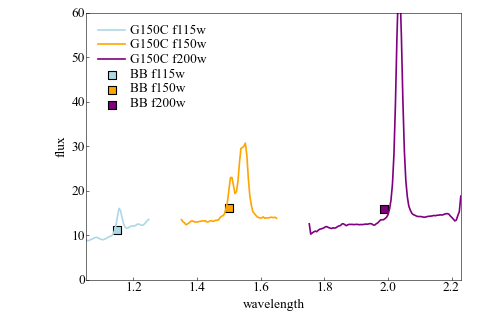

In [20]:
filts  = ['f115w', 'f150w', 'f200w']
cols   = ['lightblue', 'orange', 'purple']

for ff,filt in enumerate(filts):
    file_1d = '%sl3_nis_%s_%s_s%s_combine_1d_opt.fits'%(DIR_OUT, filt, grism, id)
    fd = fits.open(file_1d)[1].data
    wave = fd['wavelength']
    flux = fd['flux']
    flux_err = fd['uncertainty']

    con = (wave > mask_lw[ff]) & (wave < mask_uw[ff])
    plt.plot(wave[con], flux[con], ls='-', label='%s %s'%(grism, filts[ff]), color=cols[ff])

    filt_data = ascii.read('%s/NIRISS_%s.txt'%(DIR_FIL, filt.upper()))
    wave_filt = filt_data['Wavelength']
    flux_filt = filt_data['FilterTrans']

    con = (wave > mask_lw[ff]) & (wave < mask_uw[ff])
    lcen, fnu = filconv(wave_filt, flux_filt, wave[con], flux[con])
    iix = np.where(id_cat[:] == int(id))
    plt.scatter(lcen, fd_cat['F%d'%(eazy_filts[ff])][iix], marker='s', s=50, edgecolor='k', color=cols[ff], label='BB %s'%filts[ff])


plt.xlabel('wavelength')
plt.ylabel('flux')
plt.ylim(0, 60)
plt.legend(loc=0)

### Repeat for another target;

In [21]:
id = '00003'

filts = ['f115w', 'f150w', 'f200w']
eazy_filts = [309, 310, 311]
DIR_FIL = './NIRISS_Filters/DATA/'

# Masks for problematic flux at edge;
mask_lw = [1.05, 1.35, 1.75]
mask_uw = [1.25, 1.65, 2.23]

for ff, filt in enumerate(filts):
        
    for dither in dithers:
        file_1d = '%sl3_nis_%s_%s_s%s_ndither%d_1d_opt.fits'%(DIR_OUT, filt, grism, id, dither)
        fd = fits.open(file_1d)[1].data
        if dither == 0:
            wave = fd['wavelength']
            flux = np.zeros((ndither, len(wave)),'float')
            flux_err = np.zeros((ndither, len(wave)),'float')

            flux[dither,:] = fd['flux']
            flux_err[dither,:] = fd['uncertainty']
        else:
            wave_tmp = fd['wavelength']
            flux_tmp = fd['flux']
            flux_err_tmp = fd['uncertainty']

            flux[dither,:] = np.interp(wave, wave_tmp, flux_tmp)
            flux_err[dither,:] = np.sqrt(np.interp(wave, wave_tmp, flux_err_tmp[:]**2))

    # Combine;
    flux_combine = np.zeros(len(wave), 'float')
    flux_err_combine = np.zeros(len(wave), 'float')

    for ii in range(len(wave)):
        flux_combine[ii] = np.sum(flux[:,ii] * 1 / flux_err[:,ii]**2) / np.sum(1 / flux_err[:,ii]**2) 
        flux_err_combine[ii] = np.sqrt(np.sum(flux_err[:,ii]**2)) / len(flux_err[:,ii])

    # Normalize;
    filt_data = ascii.read('%s/NIRISS_%s.txt'%(DIR_FIL, filt.upper()))
    wave_filt = filt_data['Wavelength']
    flux_filt = filt_data['FilterTrans']

    con = (wave > mask_lw[ff]) & (wave < mask_uw[ff])
    lcen, fnu = filconv(wave_filt, flux_filt, wave[con], flux_combine[con])
    iix   = np.where(id_cat[:] == int(id))
    Cnorm = fd_cat['F%d'%(eazy_filts[ff])][iix] / fnu
        
    # Wirte:
    file_1d = '%sl3_nis_%s_%s_s%s_combine_1d_opt.fits'%(DIR_OUT, filt, grism, id)

    obs = Spectrum1D(spectral_axis=wave*u.um,
                     flux=flux_combine * Cnorm * u.dimensionless_unscaled,
                     uncertainty=StdDevUncertainty(flux_err_combine * Cnorm), unit='')
    obs.write(file_1d, format='tabular-fits', overwrite=True)
    

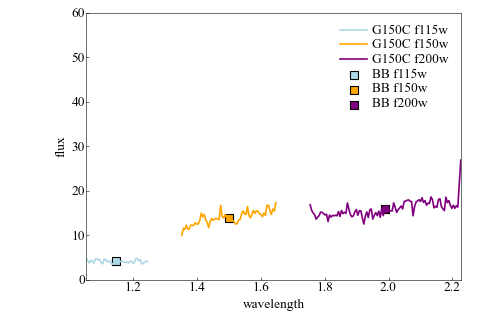

In [22]:
filts  = ['f115w', 'f150w', 'f200w']
cols   = ['lightblue', 'orange', 'purple']

for ff,filt in enumerate(filts):
    file_1d = '%sl3_nis_%s_%s_s%s_combine_1d_opt.fits'%(DIR_OUT, filt, grism, id)
    fd = fits.open(file_1d)[1].data
    wave = fd['wavelength']
    flux = fd['flux']
    flux_err = fd['uncertainty']

    con = (wave > mask_lw[ff]) & (wave < mask_uw[ff])
    plt.plot(wave[con], flux[con], ls='-', label='%s %s'%(grism, filts[ff]), color=cols[ff])

    filt_data = ascii.read('%s/NIRISS_%s.txt'%(DIR_FIL, filt.upper()))
    wave_filt = filt_data['Wavelength']
    flux_filt = filt_data['FilterTrans']

    con = (wave > mask_lw[ff]) & (wave < mask_uw[ff])
    lcen, fnu = filconv(wave_filt, flux_filt, wave[con], flux[con])
    iix = np.where(id_cat[:] == int(id))
    plt.scatter(lcen, fd_cat['F%d'%(eazy_filts[ff])][iix], marker='s', s=50, edgecolor='k', color=cols[ff], label='BB %s'%filts[ff])


plt.xlabel('wavelength')
plt.ylabel('flux')
plt.ylim(0, 60)
plt.legend(loc=0)